# Pump It Up: Data Mining the Water Table (Competition)
## DrivenData.org Practice Competition

**Can you predict which water pumps are faulty?**

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

#### Reference:
DrivenData. (2015). Pump it Up: Data Mining the Water Table. Retrieved [Month Day Year] from https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table.

In [4]:
!pip install catboost

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from catboost import CatBoostClassifier, Pool

from sklearn.metrics import classification_report, confusion_matrix, \
                            ConfusionMatrixDisplay, accuracy_score

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load data
train_label = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/train_labels.csv')
train_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/train_values.csv')
test_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/test_values.csv')
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DD Pump It Up/SubmissionFormat.csv')

Mounted at /content/drive


In [7]:
# Joining `status_group` to other features on column `id`
train_df = pd.merge(train_features, train_label, on='id')
train_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Preprocessing
- Dropped `num_private`, `recorded_by`, & `date_recorded` features
- Change `region_code` & `district_code` to 'object' type
- Change `construction_year` to 'object' type
- Convert `date_recorded` into year, month, & day features

#### Changes
- Adjust class weights via CatBoost
- OneHotEncode categorical variables via CatBoost

In [8]:
# Convert 'region_code', 'district_code', 'construction_year' to type 'object'
train_df['region_code'] = train_df['region_code'].astype('object')
train_df['district_code'] = train_df['district_code'].astype('object')
train_df['construction_year'] = train_df['construction_year'].astype('object')

test_features['region_code'] = test_features['region_code'].astype('object')
test_features['district_code'] = test_features['district_code'].astype('object')
test_features['construction_year'] = test_features['construction_year'].astype('object')

# Convert 'date_recorded' into year, month, day columns
train_df['date_recorded'] = pd.to_datetime(train_df['date_recorded'])
train_df['year_recorded'] = train_df['date_recorded'].dt.year
train_df['month_recorded'] = train_df['date_recorded'].dt.month
train_df['day_recorded'] = train_df['date_recorded'].dt.day

test_features['date_recorded'] = pd.to_datetime(test_features['date_recorded'])
test_features['year_recorded'] = test_features['date_recorded'].dt.year
test_features['month_recorded'] = test_features['date_recorded'].dt.month
test_features['day_recorded'] = test_features['date_recorded'].dt.day

# Drop columns 'num_private', 'recorded_by', 'date_recorded' (and 'id' from train_df)
train_df = train_df.drop(columns=['num_private',
                                  'recorded_by',
                                  'date_recorded',
                                  'id'])
test_features = test_features.drop(columns=['num_private',
                                            'recorded_by',
                                            'date_recorded',
                                            'id'])

In [10]:
# Fill Categorical Columns with missing values in X_train, X_test, and test_features with 'unknown'
categorical_columns = test_features.select_dtypes(include=['object']).columns

train_df[categorical_columns] = train_df[categorical_columns].fillna('unknown')
test_features[categorical_columns] = test_features[categorical_columns].fillna('unknown')

# Categorical Columns to lower case
train_df[categorical_columns] = train_df[categorical_columns].map(
    lambda x: x.lower() if isinstance(x, str) else x)
test_features[categorical_columns] = train_df[categorical_columns].map(
    lambda x: x.lower() if isinstance(x, str) else x)

In [11]:
# Split `train_df` into train and test sets before additional encoding to prevent data leakage
X = train_df.drop(columns='status_group', axis=1)
y = train_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    stratify=y, random_state=604)

Additional Preprocessing of names in `funder`, `installer`, `wpt_name`, and `scheme_name`

In [12]:
# Replace infrequent columns in 'funder', 'installer', and 'wpt_name' if less than threshold
# 200 appears to be the best threshold based on RF (vs. 100 or 300)
# Lower threshold better for CatBoost

columns_to_transform = ['funder', 'installer', 'wpt_name',
                        'subvillage', 'scheme_name', 'ward']

# Function to replace infrequent categories with 'other'
def replace_infrequent_categories(df, columns, threshold=200):
    for column in columns:
        value_counts = df[column].value_counts()
        to_replace = value_counts[value_counts <= threshold].index
        df[column] = df[column].replace(to_replace, 'other')
    return df

# Apply the function to X_train, X_test, and test_features
X_train = replace_infrequent_categories(X_train, columns_to_transform)
X_test = replace_infrequent_categories(X_test, columns_to_transform)
test_features = replace_infrequent_categories(test_features, columns_to_transform)

# CatBoost

In [13]:
# Try adjusting class weights
# Previous performance without was less than tuned RF model

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

In [14]:
# Adjust class weights if needed
class_weights_adjust = [1, 1, 1]

In [15]:
# Identify categorical feature indices
categorical_features_indices = [X.columns.get_loc(col) for col in X.select_dtypes(include=['object']).columns]

# Create a Pool
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)

# Define parameter grid
cb_param_grid = {
    'iterations': [1000],
    'depth': [10],
    'learning_rate': [0.1],
    'l2_leaf_reg': [1],
    'one_hot_max_size': [150]
}

# Best parameters: {'depth': 10, 'one_hot_max_size': 150, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500}

# Initialize CatBoost model
cb_model = CatBoostClassifier(random_state=42, class_weights=class_weights_adjust, eval_metric='Accuracy')

In [16]:
%%time
# Perform grid search
cb_gscv = cb_model.grid_search(
    cb_param_grid,
    train_pool,
    cv=3,
    verbose=False
)

0:	learn: 0.7205387	test: 0.7123617	best: 0.7123617 (0)	total: 390ms	remaining: 6m 29s
1:	learn: 0.7237554	test: 0.7172920	best: 0.7172920 (1)	total: 649ms	remaining: 5m 23s
2:	learn: 0.7277237	test: 0.7241462	best: 0.7241462 (2)	total: 933ms	remaining: 5m 10s
3:	learn: 0.7272727	test: 0.7240260	best: 0.7241462 (2)	total: 1.21s	remaining: 5m
4:	learn: 0.7290765	test: 0.7254690	best: 0.7254690 (4)	total: 1.47s	remaining: 4m 52s
5:	learn: 0.7340969	test: 0.7296777	best: 0.7296777 (5)	total: 1.75s	remaining: 4m 50s
6:	learn: 0.7364418	test: 0.7308802	best: 0.7308802 (6)	total: 2.04s	remaining: 4m 49s
7:	learn: 0.7385462	test: 0.7314815	best: 0.7314815 (7)	total: 2.31s	remaining: 4m 46s
8:	learn: 0.7382155	test: 0.7332852	best: 0.7332852 (8)	total: 2.55s	remaining: 4m 41s
9:	learn: 0.7413119	test: 0.7352092	best: 0.7352092 (9)	total: 2.83s	remaining: 4m 40s
10:	learn: 0.7423341	test: 0.7360510	best: 0.7360510 (10)	total: 3.11s	remaining: 4m 39s
11:	learn: 0.7443783	test: 0.7371332	best: 0.

In [17]:
# Access the best parameters
cb_best_params = cb_gscv['params']
print(f"Best parameters: {cb_best_params}")

Best parameters: {'depth': 10, 'one_hot_max_size': 150, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 1000}


In [18]:
# Evaluate the best model
cb_preds = cb_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, cb_preds)}")
print(classification_report(y_test, cb_preds))

Accuracy: 0.801290684624018
                         precision    recall  f1-score   support

             functional       0.80      0.89      0.84      9678
functional needs repair       0.58      0.30      0.40      1295
         non functional       0.83      0.77      0.80      6847

               accuracy                           0.80     17820
              macro avg       0.74      0.65      0.68     17820
           weighted avg       0.79      0.80      0.79     17820





```
# This is formatted as code
```

**Best Accuracy:** 0.801290684624018

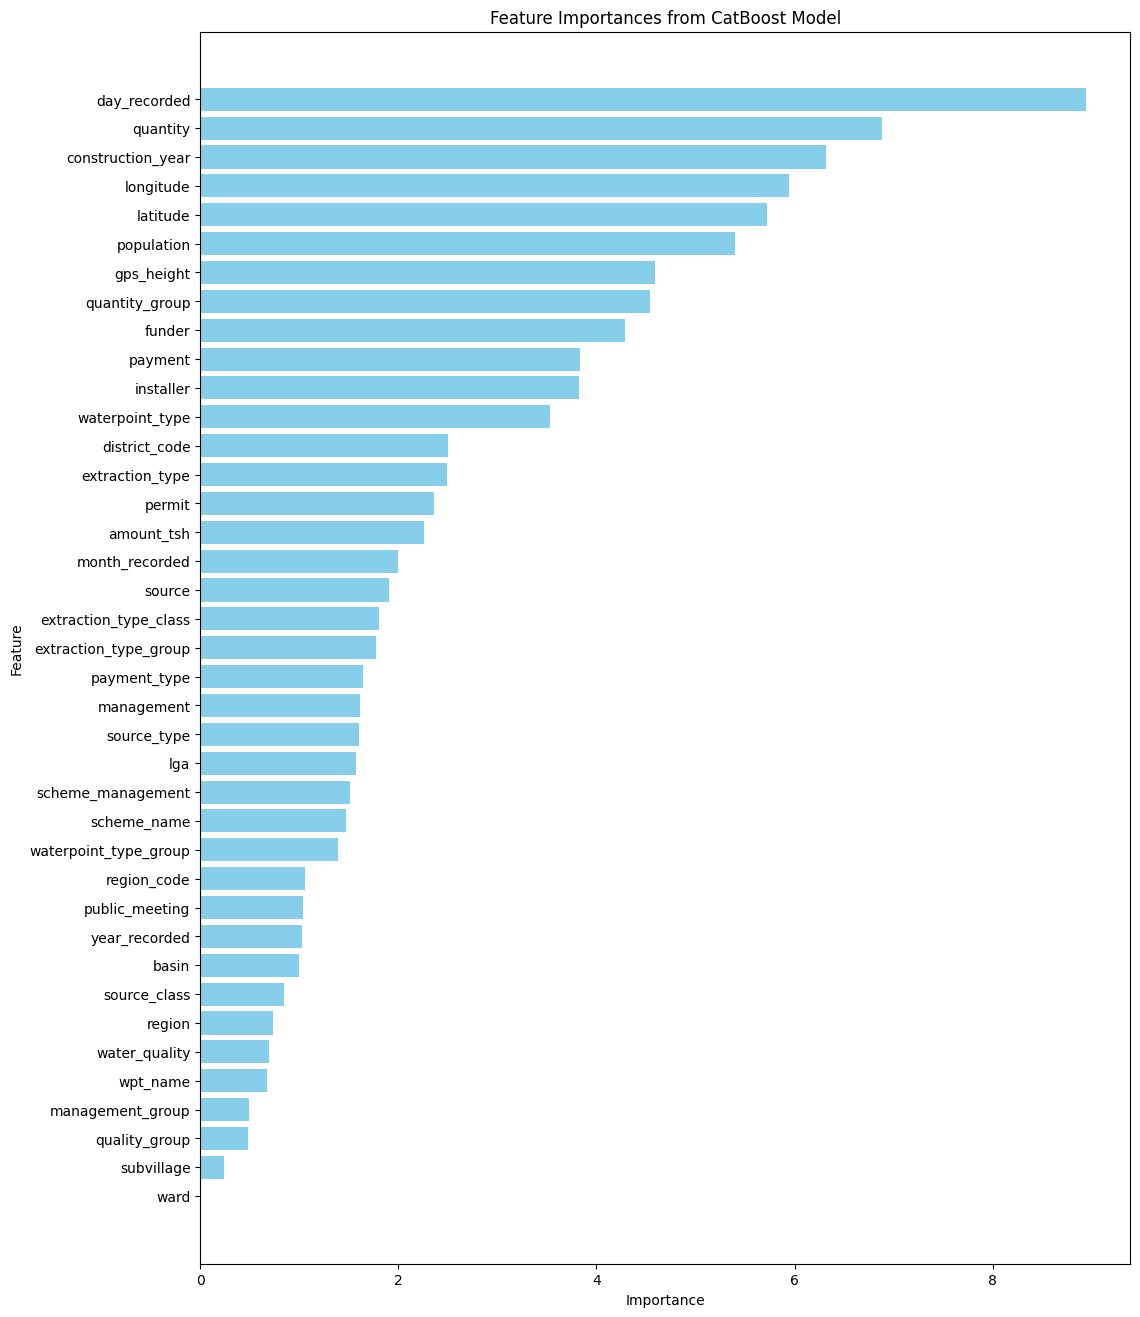

In [19]:
# Get feature importances from the CatBoost model
cb_feature_importances = cb_model.get_feature_importance()

# Create a DataFrame for better visualization
cb_features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': cb_feature_importances
})

# Sort the DataFrame by importance
cb_features_df = cb_features_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 16))
plt.barh(cb_features_df['Feature'], cb_features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from CatBoost Model')
plt.gca().invert_yaxis()
plt.show()

In [20]:
# Predict using CatBoost model
cb_test_preds = cb_model.predict(test_features)

# Ensure catboost_test_preds is a 1-dimensional array
cb_test_preds = cb_test_preds.flatten()

# Replace values in 'status_group' with catboost_test_preds
submission['status_group'] = cb_test_preds

submission.to_csv('submission_cb8.csv', index=False)